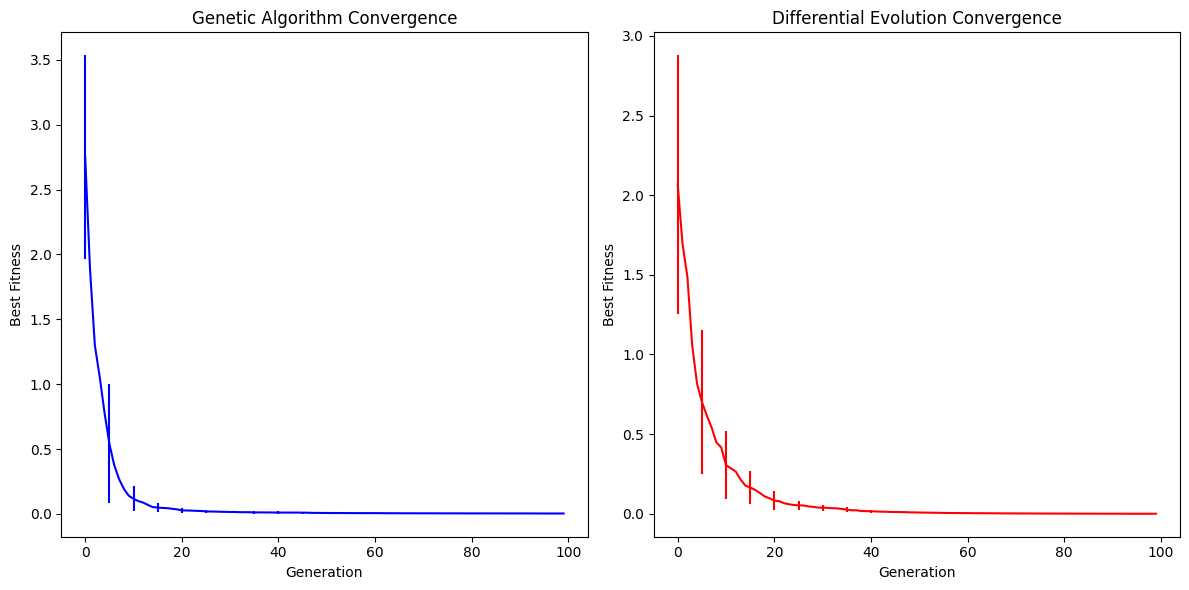

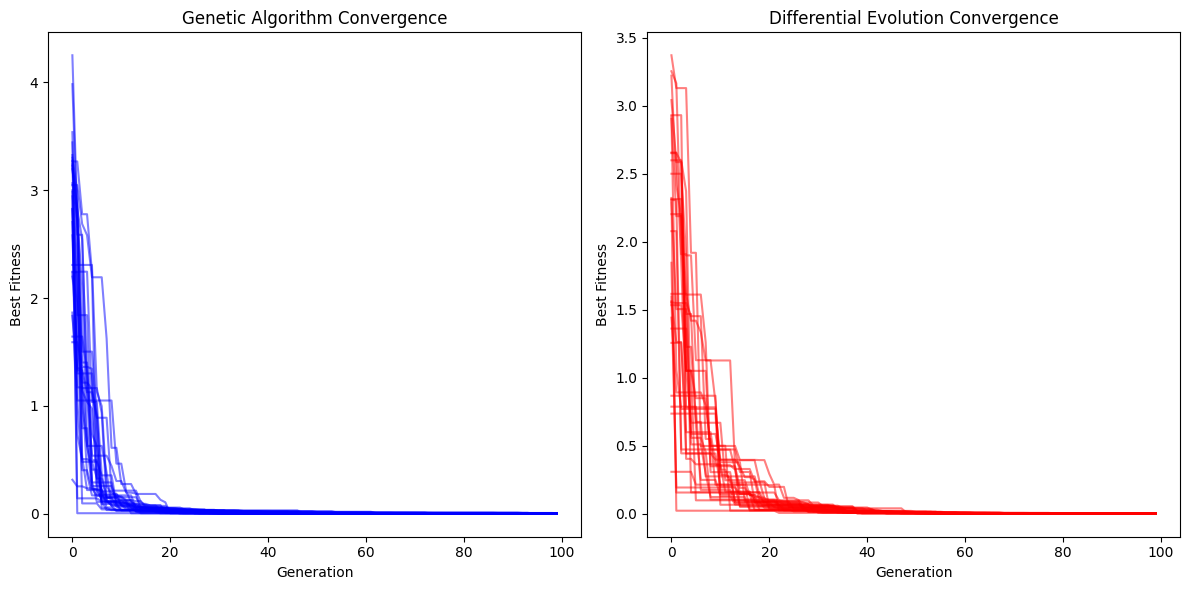

SystemExit: 0

C:\Users\MKmos\.conda\envs\EA\lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import sys
from PyQt5.QtWidgets import QApplication, QWidget, QVBoxLayout, QHBoxLayout, QLabel, QLineEdit, QPushButton, QComboBox, QTextEdit
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(101)

# Define benchmark functions
def rosen(x):
    return sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

def matyas(x):
    return 0.26 * (x[0]**2 + x[1]**2) - 0.48 * x[0] * x[1]

def dixon_price(x):
    return (x[0] - 1)**2 + sum([(i + 1) * (2 * x[i]**2 - x[i - 1])**2 for i in range(1, len(x))])

def griewank(x):
    return sum(x**2) / 4000 - np.prod(np.cos(x / np.sqrt(np.arange(1, len(x) + 1)))) + 1

def ackley(x):
    n = len(x)
    term1 = -20 * np.exp(-0.2 * np.sqrt(sum(x**2) / n))
    term2 = -np.exp(sum(np.cos(2 * np.pi * x)) / n)
    return term1 + term2 + 20 + np.exp(1)

benchmark_functions = [rosen, matyas, dixon_price, griewank, ackley]

# Genetic Algorithm for function optimization
def genetic_algorithm(
        objective_function,
        pop_size=100,
        num_generations=100,
        chromosome_length=2,
        crossover_rate=0.9,
        mutation_rate=0.1,
        selection_method=None,
        crossover_method=None,
        mutation_method=None,
        num_runs=1):

    best_solutions = []
    best_fitnesses = []
    all_best_fitnesses = []

    for _ in range(num_runs):
        # Initialize population randomly within a given range
        population = np.random.uniform(-5, 5, (pop_size, chromosome_length))

        # Initialize best fitness and best solution
        best_fitness = float('inf')
        best_solution = None
        best_fitnesses_run = []

        for generation in range(num_generations):
            # Evaluate fitness of each individual
            fitness = np.array([objective_function(ind) for ind in population])

            # Track the best solution
            if fitness.min() < best_fitness:
                best_fitness = fitness.min()
                best_solution = population[fitness.argmin()]
            best_fitnesses_run.append(best_fitness)

            # Selection: Choose parents based on the selected method
            parents = selection_method(population, fitness, pop_size)

            # Crossover and mutation
            offspring = []
            for i in range(0, pop_size, 2):
                # Perform crossover with a given probability
                if np.random.rand() < crossover_rate:
                    child1, child2 = crossover_method(parents[i], parents[i + 1])
                else:
                    # If chromosome length is too small, skip crossover
                    child1, child2 = parents[i], parents[i + 1]

                # Mutation
                child1 = mutation_method(child1, mutation_rate)
                child2 = mutation_method(child2, mutation_rate)

                offspring.append(child1)
                offspring.append(child2)

            # Replace the old population with the new offspring
            population = np.array(offspring)

        all_best_fitnesses.append(best_fitnesses_run)
        # Store the best solution and its fitness for this run
        best_solutions.append(best_solution)
        best_fitnesses.append(best_fitness)

    # Return the list of best solutions and best fitnesses for all runs
    return best_solutions, best_fitnesses, all_best_fitnesses

# Differential Evolution Algorithm for function optimization
def differential_evolution(
        objective_function,
        pop_size=100,
        num_generations=100,
        chromosome_length=2,
        crossover_rate=0.9,
        scaling_factor=0.5,
        num_runs=1):

    best_solutions = []
    best_fitnesses = []
    all_best_fitnesses = []

    for _ in range(num_runs):
        # Initialize population randomly within a given range
        population = np.random.uniform(-5, 5, (pop_size, chromosome_length))

        # Initialize best fitness and best solution
        best_fitness = float('inf')
        best_solution = None
        best_fitnesses_run = []

        for generation in range(num_generations):
            for i in range(pop_size):
                # Select three distinct individuals from population
                candidates = np.random.choice(range(pop_size), size=3, replace=False)
                target, donor1, donor2 = population[i], population[candidates[0]], population[candidates[1]]

                # Mutation: Generate trial vector
                trial_vector = target + scaling_factor * (donor1 - donor2)

                # Crossover: Binomial crossover
                for j in range(chromosome_length):
                    if np.random.rand() > crossover_rate:
                        trial_vector[j] = target[j]

                # Selection: Greedy selection
                if objective_function(trial_vector) < objective_function(target):
                    population[i] = trial_vector

            # Track the best solution
            fitness = np.array([objective_function(ind) for ind in population])
            if fitness.min() < best_fitness:
                best_fitness = fitness.min()
                best_solution = population[fitness.argmin()]
            best_fitnesses_run.append(best_fitness)

        all_best_fitnesses.append(best_fitnesses_run)
        # Store the best solution and its fitness for this run
        best_solutions.append(best_solution)
        best_fitnesses.append(best_fitness)

    # Return the list of best solutions and best fitnesses for all runs
    return best_solutions, best_fitnesses, all_best_fitnesses

# GUI for both Genetic Algorithm and Differential Evolution Algorithm
class OptimizationGUI(QWidget):
    def __init__(self):
        super().__init__()
        self.initUI()

    def initUI(self):
        layout = QVBoxLayout()

        # Function selection for Genetic Algorithm
        func_label_ga = QLabel("Choose a function to optimize (Genetic Algorithm):")
        self.func_combo_ga = QComboBox()
        for func in benchmark_functions:
            self.func_combo_ga.addItem(func.__name__)
        layout.addWidget(func_label_ga)
        layout.addWidget(self.func_combo_ga)

        # Function selection for Differential Evolution Algorithm
        func_label_de = QLabel("Choose a function to optimize (Differential Evolution):")
        self.func_combo_de = QComboBox()
        for func in benchmark_functions:
            self.func_combo_de.addItem(func.__name__)
        layout.addWidget(func_label_de)
        layout.addWidget(self.func_combo_de)

        # Parameters input for Genetic Algorithm
        parameters_layout_ga = QHBoxLayout()
        parameters_layout_ga.addWidget(QLabel("Population Size (GA):"))
        self.pop_size_input_ga = QLineEdit("100")
        parameters_layout_ga.addWidget(self.pop_size_input_ga)
        parameters_layout_ga.addWidget(QLabel("Number of Generations (GA):"))
        self.num_generations_input_ga = QLineEdit("100")
        parameters_layout_ga.addWidget(self.num_generations_input_ga)
        parameters_layout_ga.addWidget(QLabel("Crossover Rate (GA):"))
        self.crossover_rate_input_ga = QLineEdit("0.9")
        parameters_layout_ga.addWidget(self.crossover_rate_input_ga)
        parameters_layout_ga.addWidget(QLabel("Mutation Rate (GA):"))
        self.mutation_rate_input_ga = QLineEdit("0.1")
        parameters_layout_ga.addWidget(self.mutation_rate_input_ga)

        # Add parent selection method selection for Genetic Algorithm
        parameters_layout_ga.addWidget(QLabel("Parent Selection Method (GA):"))
        self.parent_selection_combo_ga = QComboBox()
        self.parent_selection_combo_ga.addItems(["Tournament Selection", "Roulette Wheel Selection"])
        parameters_layout_ga.addWidget(self.parent_selection_combo_ga)

        # Add recombination technique selection for Genetic Algorithm
        parameters_layout_ga.addWidget(QLabel("Recombination Technique (GA):"))
        self.recombination_combo_ga = QComboBox()
        self.recombination_combo_ga.addItems(["Single Point Crossover", "Uniform Crossover"])
        parameters_layout_ga.addWidget(self.recombination_combo_ga)

        # Add mutation technique selection for Genetic Algorithm
        parameters_layout_ga.addWidget(QLabel("Mutation Technique (GA):"))
        self.mutation_combo_ga = QComboBox()
        self.mutation_combo_ga.addItems(["Uniform Mutation", "Gaussian Mutation"])
        parameters_layout_ga.addWidget(self.mutation_combo_ga)

        layout.addLayout(parameters_layout_ga)

        # Parameters input for Differential Evolution
        parameters_layout_de = QHBoxLayout()
        parameters_layout_de.addWidget(QLabel("Population Size (DE):"))
        self.pop_size_input_de = QLineEdit("100")
        parameters_layout_de.addWidget(self.pop_size_input_de)
        parameters_layout_de.addWidget(QLabel("Number of Generations (DE):"))
        self.num_generations_input_de = QLineEdit("100")
        parameters_layout_de.addWidget(self.num_generations_input_de)
        parameters_layout_de.addWidget(QLabel("Crossover Rate (DE):"))
        self.crossover_rate_input_de = QLineEdit("0.9")
        parameters_layout_de.addWidget(self.crossover_rate_input_de)
        parameters_layout_de.addWidget(QLabel("Scaling Factor (DE):"))
        self.scaling_factor_input_de = QLineEdit("0.5")
        parameters_layout_de.addWidget(self.scaling_factor_input_de)
        layout.addLayout(parameters_layout_de)

        # Number of runs input
        num_runs_layout = QHBoxLayout()
        num_runs_label = QLabel("Number of runs:")
        self.num_runs_input = QLineEdit("30")
        num_runs_layout.addWidget(num_runs_label)
        num_runs_layout.addWidget(self.num_runs_input)
        layout.addLayout(num_runs_layout)

        # Start button
        start_button = QPushButton("Start Optimization")
        start_button.clicked.connect(self.start_optimization)
        layout.addWidget(start_button)

        # Results display
        self.results_text = QTextEdit()
        layout.addWidget(self.results_text)

        self.setLayout(layout)
        self.setWindowTitle("Genetic and Differential Evolution Algorithm Optimization")

    def start_optimization(self):
        choice_ga = self.func_combo_ga.currentIndex()
        pop_size_ga = int(self.pop_size_input_ga.text())
        num_generations_ga = int(self.num_generations_input_ga.text())
        crossover_rate_ga = float(self.crossover_rate_input_ga.text())
        mutation_rate_ga = float(self.mutation_rate_input_ga.text())

        parent_selection_method_ga = self.parent_selection_combo_ga.currentText()
        if parent_selection_method_ga == "Tournament Selection":
            selection_method_ga = tournament_selection
        else:
            selection_method_ga = roulette_wheel_selection

        recombination_technique_ga = self.recombination_combo_ga.currentText()
        if recombination_technique_ga == "Single Point Crossover":
            crossover_method_ga = single_point_crossover
        else:
            crossover_method_ga = uniform_crossover

        mutation_technique_ga = self.mutation_combo_ga.currentText()
        if mutation_technique_ga == "Uniform Mutation":
            mutation_method_ga = uniform_mutation
        else:
            mutation_method_ga = gaussian_mutation

        choice_de = self.func_combo_de.currentIndex()
        pop_size_de = int(self.pop_size_input_de.text())
        num_generations_de = int(self.num_generations_input_de.text())
        crossover_rate_de = float(self.crossover_rate_input_de.text())
        scaling_factor_de = float(self.scaling_factor_input_de.text())

        num_runs = int(self.num_runs_input.text())

        # Run Genetic Algorithm
        best_solutions_ga, best_fitnesses_ga, all_best_fitnesses_ga = genetic_algorithm(
            objective_function=benchmark_functions[choice_ga],
            pop_size=pop_size_ga,
            num_generations=num_generations_ga,
            crossover_rate=crossover_rate_ga,
            mutation_rate=mutation_rate_ga,
            selection_method=selection_method_ga,
            crossover_method=crossover_method_ga,
            mutation_method=mutation_method_ga,
            num_runs=num_runs
        )

        # Run Differential Evolution Algorithm
        best_solutions_de, best_fitnesses_de, all_best_fitnesses_de = differential_evolution(
            objective_function=benchmark_functions[choice_de],
            pop_size=pop_size_de,
            num_generations=num_generations_de,
            crossover_rate=crossover_rate_de,
            scaling_factor=scaling_factor_de,
            num_runs=num_runs
        )

        self.results_text.clear()
        self.results_text.append("Results for Genetic Algorithm:")
        self.results_text.append(f"Optimized function: {benchmark_functions[choice_ga].__name__}")
        for i in range(num_runs):
            self.results_text.append(f"Run {i+1}: Best solution: {best_solutions_ga[i]}, Best fitness: {best_fitnesses_ga[i]}")

        self.results_text.append("\nResults for Differential Evolution:")
        self.results_text.append(f"Optimized function: {benchmark_functions[choice_de].__name__}")
        for i in range(num_runs):
            self.results_text.append(f"Run {i+1}: Best solution: {best_solutions_de[i]}, Best fitness: {best_fitnesses_de[i]}")

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        all_best_fitnesses_ga = np.array(all_best_fitnesses_ga)
        average_fitness_ga = np.mean(all_best_fitnesses_ga, axis=0)
        std_fitness_ga = np.std(all_best_fitnesses_ga, axis=0)
        plt.errorbar(range(num_generations_ga), average_fitness_ga, yerr=std_fitness_ga, fmt='-b', errorevery=5)
        plt.title('Genetic Algorithm Convergence')
        plt.xlabel('Generation')
        plt.ylabel('Best Fitness')
        
        plt.subplot(1, 2, 2)
        all_best_fitnesses_de = np.array(all_best_fitnesses_de)
        average_fitness_de = np.mean(all_best_fitnesses_de, axis=0)
        std_fitness_de = np.std(all_best_fitnesses_de, axis=0)
        plt.errorbar(range(num_generations_de), average_fitness_de, yerr=std_fitness_de, fmt='-r', errorevery=5)
        plt.title('Differential Evolution Convergence')
        plt.xlabel('Generation')
        plt.ylabel('Best Fitness')
        
        plt.tight_layout()
        plt.show()
        

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        for run in all_best_fitnesses_ga:
            plt.plot(range(num_generations_ga), run, 'b-', alpha=0.5)
        plt.title('Genetic Algorithm Convergence')
        plt.xlabel('Generation')
        plt.ylabel('Best Fitness')
        
        plt.subplot(1, 2, 2)
        for run in all_best_fitnesses_de:
            plt.plot(range(num_generations_de), run, 'r-', alpha=0.5)
        plt.title('Differential Evolution Convergence')
        plt.xlabel('Generation')
        plt.ylabel('Best Fitness')

        plt.tight_layout()
        plt.show()

# Rest of the code remains the same
def tournament_selection(population, fitness, pop_size, tournament_size=2):
    selected_parents = []
    for _ in range(pop_size):
        selected_indices = np.random.randint(0, pop_size, tournament_size)
        # Choose the best individual from the tournament
        best_index = selected_indices[np.argmin(fitness[selected_indices])]
        selected_parents.append(population[best_index])
    return selected_parents

def roulette_wheel_selection(population, fitness, pop_size):
    # Normalize fitness to create a probability distribution
    fitness = 1 / (1 + fitness)  # Transform fitness values to probabilities
    probabilities = fitness / sum(fitness)

    selected_parents = []
    for _ in range(pop_size):
        # Choose an individual based on the probability distribution
        selected_index = np.random.choice(range(pop_size), p=probabilities)
        selected_parents.append(population[selected_index])

    return selected_parents

# Crossover methods
def single_point_crossover(parent1, parent2):
    """Perform single-point crossover."""
    crossover_point = np.random.randint(1, len(parent1))
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

def uniform_crossover(parent1, parent2):
    """Perform uniform crossover."""
    mask = np.random.randint(0, 2, size=len(parent1), dtype=bool)
    child1 = np.where(mask, parent1, parent2)
    child2 = np.where(mask, parent2, parent1)
    return child1, child2

# Mutation methods
def uniform_mutation(individual, mutation_rate):
    """Perform uniform mutation."""
    mask = np.random.rand(len(individual)) < mutation_rate
    individual[mask] += np.random.uniform(-0.5, 0.5, mask.sum())
    return individual

def gaussian_mutation(individual, mutation_rate):
    """Perform Gaussian mutation."""
    mask = np.random.rand(len(individual)) < mutation_rate
    individual[mask] += np.random.normal(0, 0.1, mask.sum())
    return individual

def main():
    app = QApplication(sys.argv)
    window = OptimizationGUI()
    window.show()
    sys.exit(app.exec_())

if __name__ == '__main__':
    main()
